<a href="https://colab.research.google.com/github/imvignesh003/SocialMediaChannalizationML/blob/main/SocialKNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [2]:
!kaggle datasets download -d moazeldsokyx/bbc-news

! unzip "bbc-news.zip"

Dataset URL: https://www.kaggle.com/datasets/moazeldsokyx/bbc-news
License(s): unknown
100% 1.83M/1.83M [00:00<00:00, 2.33MB/s]
100% 1.83M/1.83M [00:00<00:00, 2.06MB/s]
Archive:  bbc-news.zip
  inflating: bbc-text.csv            


In [3]:
import pandas as pd
import numpy as np
import re
import string
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
df = pd.read_csv('/content/bbc-text.csv')

In [5]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [6]:
categories = df['category'].unique()
categories

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [7]:
category_map = {
    'tech': 'productivity',
    'business': 'productivity',
    'politics': 'productivity',
    'entertainment': 'entertainment',
    'sport': 'entertainment'
}
df['label'] = df['category'].map(category_map)

In [8]:
df.drop(columns=['category'], inplace=True)

In [9]:
df.head()

,text,label
0,tv future in the hands of viewers with home th...,productivity
1,worldcom boss left books alone former worldc...,productivity
2,tigers wary of farrell gamble leicester say ...,entertainment
3,yeading face newcastle in fa cup premiership s...,entertainment
4,ocean s twelve raids box office ocean s twelve...,entertainment


In [10]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['cleaned_text'] = df['text'].apply(preprocess_text)

In [11]:
df.head()

,text,label,cleaned_text
0,tv future in the hands of viewers with home th...,productivity,tv future in the hands of viewers with home th...
1,worldcom boss left books alone former worldc...,productivity,worldcom boss left books alone former worldc...
2,tigers wary of farrell gamble leicester say ...,entertainment,tigers wary of farrell gamble leicester say ...
3,yeading face newcastle in fa cup premiership s...,entertainment,yeading face newcastle in fa cup premiership s...
4,ocean s twelve raids box office ocean s twelve...,entertainment,ocean s twelve raids box office ocean s twelve...


In [14]:
# Vectorization for KNN & SVM
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['label'].map({'productivity': 0, 'entertainment': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# # Train KNN model
# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train, y_train)

# # Make predictions
# y_pred = knn.predict(X_test)

# # Evaluate model
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy:.4f}')
# print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))
# Train KNN model
knn = KNeighborsClassifier(n_neighbors=5)
train_accuracies = []
test_accuracies = []
n_neighbors_range = range(1, 21)

In [16]:
# Train KNN model
knn = KNeighborsClassifier(n_neighbors=5)
train_accuracies = []
test_accuracies = []
n_neighbors_range = range(1, 21)

for k in n_neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracies.append(knn.score(X_train, y_train))
    test_accuracies.append(knn.score(X_test, y_test))

In [17]:
# Make predictions
y_pred = knn.predict(X_test)

In [18]:
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9528
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       266
           1       0.99      0.89      0.94       179

    accuracy                           0.95       445
   macro avg       0.96      0.94      0.95       445
weighted avg       0.95      0.95      0.95       445

[[264   2]
 [ 19 160]]


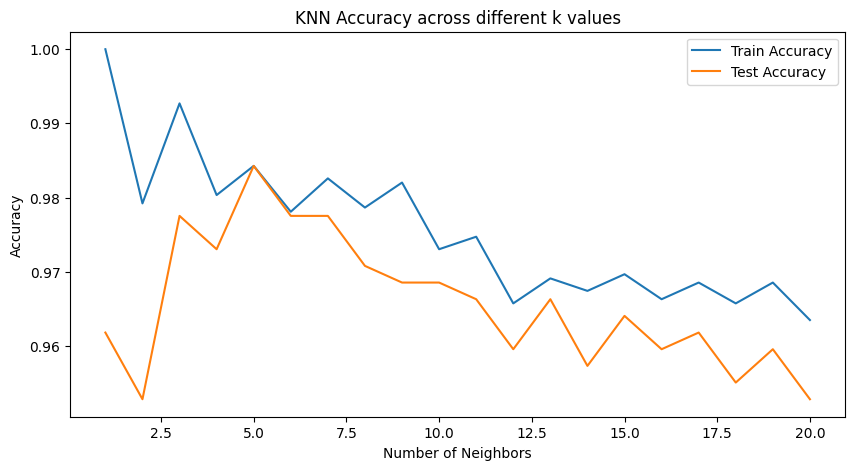

In [19]:
# Visualization of accuracy trends
plt.figure(figsize=(10, 5))
plt.plot(n_neighbors_range, train_accuracies, label='Train Accuracy')
plt.plot(n_neighbors_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy across different k values')
plt.legend()
plt.show()

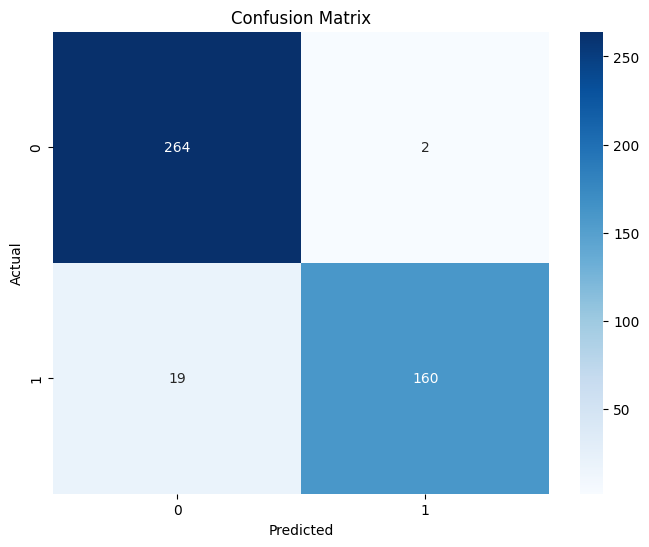

In [20]:
# Confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [25]:
processed_post = preprocess_text('I am going to a work in my project this weekend')
vectorized_post = vectorizer.transform([processed_post])
prediction = knn.predict(vectorized_post)
result = {"category": "Productivity" if prediction == 0 else "Entertainment"}
result

{'category': 'Entertainment'}

In [ ]:
# Save the model
trainer.save_model("./saved_model")

# Save the tokenizer (if not already saved)
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer.save_pretrained("./saved_model")

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

In [ ]:
import shutil

# Compress the directory
shutil.make_archive("saved_model", "zip", "./saved_model")

'/content/saved_model.zip'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path in Google Drive
save_path = "/content/drive/MyDrive/saved_model"

# Save the model
trainer.save_model(save_path)

# Save the tokenizer (if not already saved)
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/saved_model/tokenizer_config.json',
 '/content/drive/MyDrive/saved_model/special_tokens_map.json',
 '/content/drive/MyDrive/saved_model/vocab.txt',
 '/content/drive/MyDrive/saved_model/added_tokens.json')